## Autoregression Model

In [2]:
import pandas as pd

foot_traffic_df = pd.read_csv("data/foot_traffic.csv")

foot_traffic_df.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


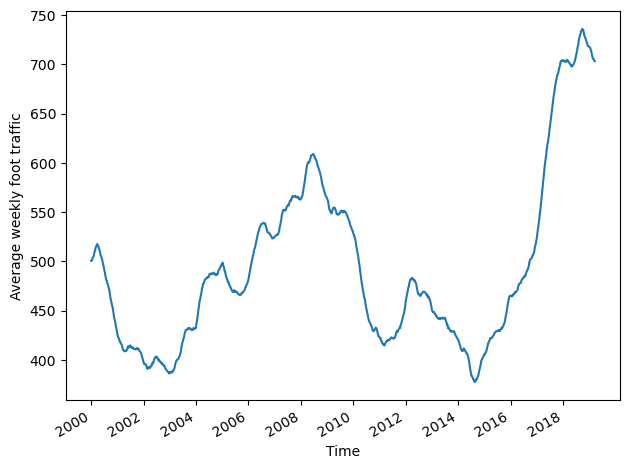

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

ax.plot(foot_traffic_df["foot_traffic"])
ax.set_xlabel("Time")
ax.set_ylabel("Average weekly foot traffic")

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
from statsmodels.tsa.stattools import adfuller

ADF_test_results = adfuller(foot_traffic_df)
print(f"Adf statistics: {ADF_test_results[0]}")
print(f"p-value: {ADF_test_results[1]}")

Adf statistics: -1.1758885999240747
p-value: 0.683880891789619


In [5]:
# Make timeseries stationary

foot_traffic_df_diff = np.diff(foot_traffic_df["foot_traffic"], n=1)

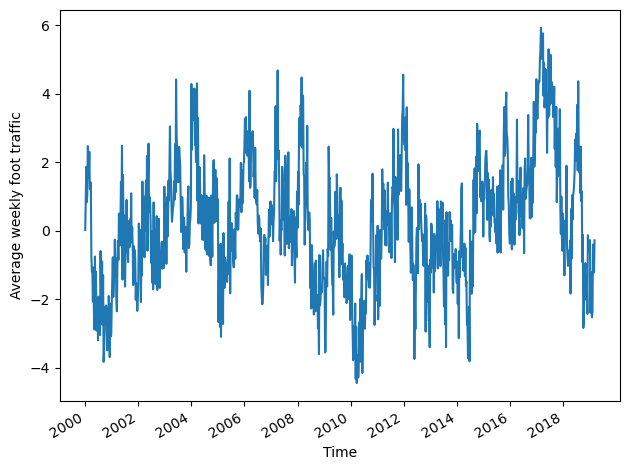

In [6]:
fig, ax = plt.subplots()

ax.plot(foot_traffic_df_diff)
ax.set_xlabel("Time")
ax.set_ylabel("Average weekly foot traffic")

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [7]:
# Check modified timeseries for stationarity

ADF_diff_results = adfuller(foot_traffic_df_diff)
print(f"ADF statistics for diff: {ADF_diff_results[0]}")
print(f"p-value: {ADF_diff_results[1]}")

ADF statistics for diff: -5.268231347422044
p-value: 6.369317654781239e-06


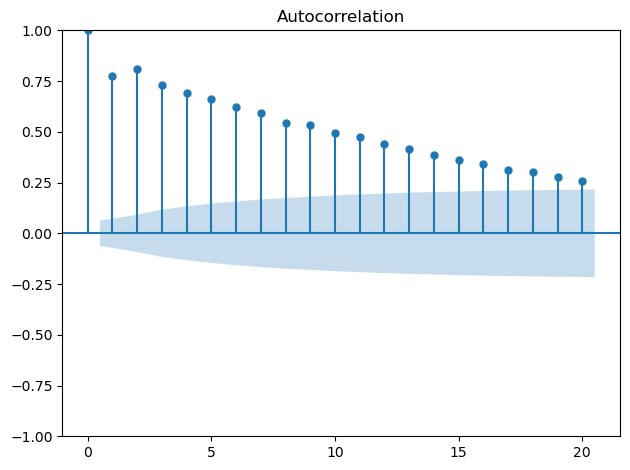

In [8]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(foot_traffic_df_diff, lags=20)

plt.tight_layout()

In [9]:
# Sample autoregressive process

from statsmodels.tsa.arima_process import ArmaProcess

np.random.seed(11)

ma2 = np.array([1, 0, 0])
ar2 = np.array([1, -0.33, -0.50])

AR2_process = ArmaProcess(ar=ar2, ma=ma2).generate_sample(nsample=1000)

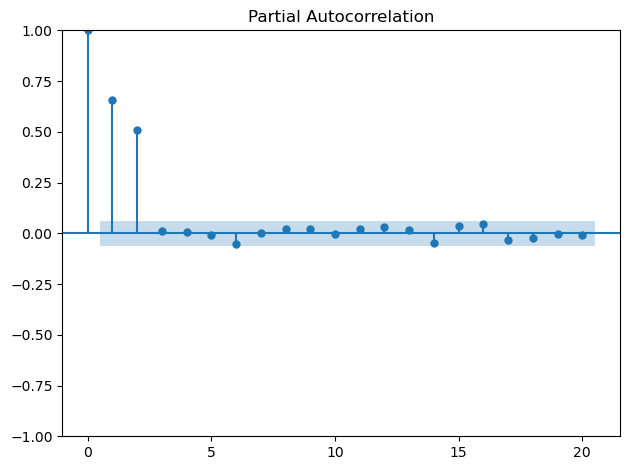

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(AR2_process, lags=20)

plt.tight_layout()

In [11]:
# Forecasting autoregressive process

new_foot_traffic_df = pd.DataFrame({
    "foot_traffic_df": foot_traffic_df_diff
})

train = new_foot_traffic_df[:-52]
test = new_foot_traffic_df[-52:]

print(len(train))
print(len(test))

947
52


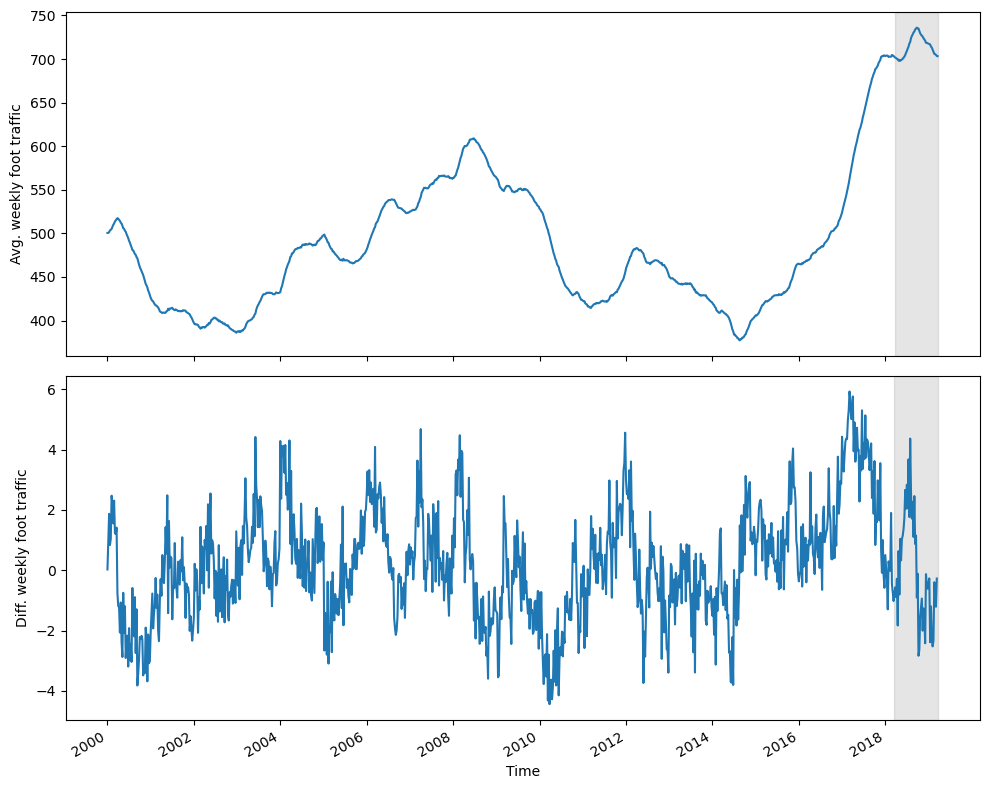

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(foot_traffic_df["foot_traffic"])
ax1.set_xlabel("Time")
ax1.set_ylabel("Avg. weekly foot traffic")
ax1.axvspan(948, 1000, color="#808080", alpha=0.2)

ax2.plot(new_foot_traffic_df["foot_traffic_df"])
ax2.set_xlabel("Time")
ax2.set_ylabel("Diff. weekly foot traffic")
ax2.axvspan(947, 999, color="#808080", alpha=0.2)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [13]:
# helper function to forecast on a horizon
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str):

    total_len = train_len + horizon
    end_idx = train_len

    if method == "last":
        pred_last_value = []
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
        
        return pred_last_value
    
    elif method == "mean":
        pred_mean = []
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
        
        return pred_mean
    
    elif method == "AR":
        pred_AR = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3, 0, 0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
        
        return pred_AR
    

In [15]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(new_foot_traffic_df, TRAIN_LEN, HORIZON, WINDOW, "mean")
pred_last_value = rolling_forecast(new_foot_traffic_df, TRAIN_LEN, HORIZON, WINDOW, "last")
pred_AR = rolling_forecast(new_foot_traffic_df, TRAIN_LEN, HORIZON, WINDOW, "AR")

test["pred_mean"] = pred_mean
test["pred_last_value"] = pred_last_value
test["pred_AR"] = pred_AR

test.head()


/tmp/ipykernel_7583/1921424720.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred_mean"] = pred_mean
/tmp/ipykernel_7583/1921424720.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["pred_last_value"] = pred_last_value
/tmp/ipykernel_7583/1921424720.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

,foot_traffic_df,pred_mean,pred_last_value,pred_AR
947,-0.776601,0.213270,-1.021893,-0.719714
948,-0.574631,0.212226,-0.776601,-0.814547
949,-0.890697,0.211397,-0.574631,-0.664738
950,-0.283552,0.210237,-0.890697,-0.641469
951,-1.830685,0.209717,-0.283552,-0.579279


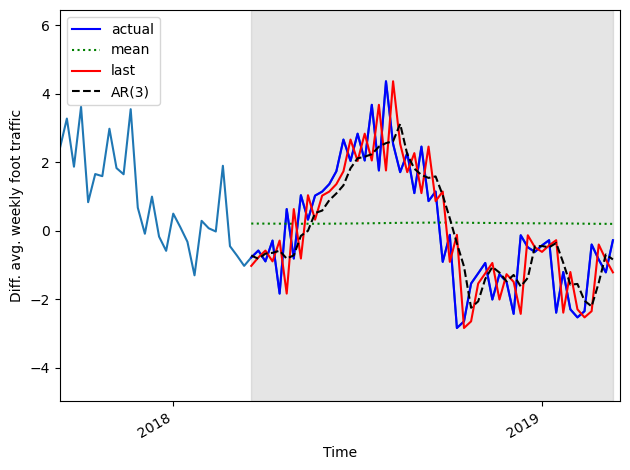

In [16]:
# Plot forecasts

fig, ax = plt.subplots()

ax.plot(new_foot_traffic_df["foot_traffic_df"])
ax.plot(test["foot_traffic_df"], "b-", label="actual")
ax.plot(test["pred_mean"], "g:", label="mean")
ax.plot(test["pred_last_value"], "r-", label="last")
ax.plot(test["pred_AR"], "k--", label="AR(3)")

ax.legend(loc=2)

ax.set_xlabel("Time")
ax.set_ylabel("Diff. avg. weekly foot traffic")

ax.axvspan(947, 998, color="#808080", alpha=0.2)

ax.set_xlim(920, 999)

plt.xticks([936, 988], [2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [17]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test["foot_traffic_df"], test["pred_mean"])
mse_last = mean_squared_error(test["foot_traffic_df"], test["pred_last_value"])
mse_AR = mean_squared_error(test["foot_traffic_df"], test["pred_AR"])

print(mse_mean, mse_last, mse_AR)

3.1079979374701447 1.448730118495964 0.9242479164643418


In [18]:
foot_traffic_df["pred_foot_traffic"] = pd.Series()
foot_traffic_df["pred_foot_traffic"][948:] = foot_traffic_df["foot_traffic"].iloc[948] + test["pred_AR"].cumsum()

/tmp/ipykernel_7583/1508764961.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foot_traffic_df["pred_foot_traffic"][948:] = foot_traffic_df["foot_traffic"].iloc[948] + test["pred_AR"].cumsum()


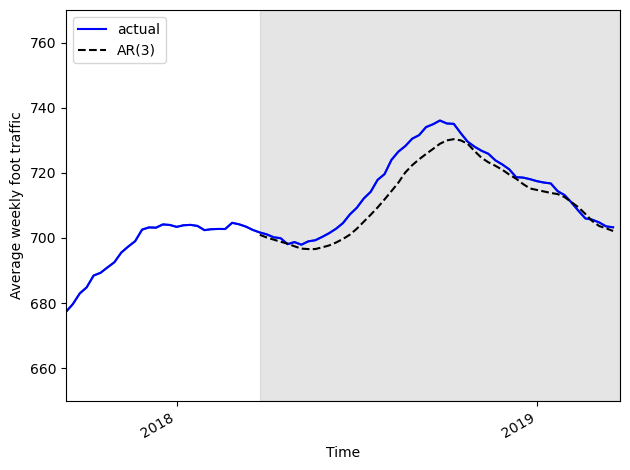

In [19]:
fig, ax = plt.subplots()

ax.plot(foot_traffic_df["foot_traffic"])
ax.plot(foot_traffic_df["foot_traffic"], "b-", label="actual")
ax.plot(foot_traffic_df["pred_foot_traffic"], "k--", label="AR(3)")

ax.legend(loc=2)

ax.set_xlabel("Time")
ax.set_ylabel("Average weekly foot traffic")

ax.axvspan(948, 1000, color="#808080", alpha=0.2)

ax.set_xlim(920, 1000)
ax.set_ylim(650, 770)

plt.xticks([936, 988], [2018, 2019])

fig.autofmt_xdate()
plt.tight_layout()

In [20]:
from sklearn.metrics import mean_absolute_error

mae_AR_undiff = mean_absolute_error(foot_traffic_df["foot_traffic"][948:], foot_traffic_df["pred_foot_traffic"][948:])

print(mae_AR_undiff)

3.4780335575911225
